In [1]:
import argparse
import numpy as np
import pinocchio
from mim_control_cpp import (
    CentroidalImpedanceController
)
# %matplotlib notebook
# %matplotlib inline
import matplotlib.pylab as plt
from bullet_utils.env import BulletEnvWithGround
from robot_properties_solo.solo12wrapper import Solo12Robot, Solo12Config

import time

plt.rcParams['figure.dpi'] = 144  # makes plots bigger, default = 72.0

In [2]:
# Create a Pybullet simulation environment
env = BulletEnvWithGround()

# Create a robot instance in the simulator.
robot = Solo12Robot()
robot = env.add_robot(robot)
robot_config = Solo12Config()
mu = 0.2
kc = np.array([200, 200, 200])
dc = np.array([50, 50, 50])
kb = np.array([100, 100, 200])
db = np.array([50.0, 50.0, 200.0])
qp_penalty_weights = np.array([5e5, 5e5, 5e5, 1e6, 1e6, 1e6])

# impedance gains
kp = np.array([200, 200, 200, 0, 0, 0])
kd = np.array([10.0, 10.0, 10.0, 0, 0, 0])

pin_robot = robot.pin_robot

q_init = robot_config.q0.copy()
q_init[0] = 0.

In [3]:
robot.reset_state(q_init, robot_config.v0)

ctrl = CentroidalImpedanceController()
ctrl.initialize(
    2.5,
    np.diag(robot.pin_robot.mass(q_init)[3:6, 3:6]),
    pin_robot.model,
    "universe",
    robot_config.end_effector_names,
    mu,
    qp_penalty_weights,
    kc, dc, kb, db,
    kp, kd
)

# Desired center of mass position and velocity.
x_com = [0.0, 0.0, 0.25]
xd_com = [0.0, 0.0, 0.0]
# The base should be flat.
x_ori = [0.0, 0.0, 0.0, 1.0]
x_angvel = [0.0, 0.0, 0.0]

# Desired leg length
x_des = [
     0.195,  0.147, 0.015, 0, 0, 0, 1.,
     0.195, -0.147, 0.015, 0, 0, 0, 1.,
    -0.195,  0.147, 0.015, 0, 0, 0, 1.,
    -0.195, -0.147, 0.015, 0, 0, 0, 1.
]
# x_des = np.array([
#      0.195,  0.147, 0.015, 0, 0, 0, 1.,
#      0.195, -0.147, 0.015, 0, 0, 0, 1.,
#     -0.195,  0.147, 0.015, 0, 0, 0, 1.,
#     -0.195, -0.147, 0.015, 0, 0, 0, 1.
# ])

xd_des = np.zeros(4 * 6)

dur = 0.

contact_array = np.ones(4)

def switch_legs(reverse = False):
    up, down = 0.2, 0.015
    if (x_des[2] == down) != reverse:
        x_des[2::7] = (up, down, down, up)
    else:
        x_des[2::7] = (down, up, up, down)
        
        
def contact_map(n):
    global contact_array
    global x_des
    
    up, down = x_com[2]/2 , 0.015
    
    contact_duration = 250
    overlap_duration = 50
    initial_duration = 50
    
    if n < initial_duration:
        contact_array = np.ones(4)
        return
    
    
    if (n - initial_duration) % (2 * contact_duration) == 0:
        contact_array = np.array((1, 0, 0, 1))
        x_des[2::7] = (down, up, up, down)
        return
    
    if (n - initial_duration) % (2 * contact_duration) == contact_duration - overlap_duration:
        contact_array = np.ones(4)
        x_des[2::7] = (down, down, down, down)
        return
        
    if (n - initial_duration) % (2 * contact_duration) == contact_duration:
        contact_array = np.array((0, 1, 1, 0))
        x_des[2::7] = (up, down, down, up)
        return
        
    if (n - initial_duration) % (2 * contact_duration) == (2 * contact_duration - overlap_duration):
        contact_array = np.array((1, 1, 1, 1))
        x_des[2::7] = (down, down, down, down)
        return
        

In [4]:
N = 4000

grfs = np.empty((N, 4, 3))
contact = np.empty((N, 4))
contact_hardcoded = np.empty((N, 4))


In [6]:
# Run the simulator for N steps
contact_status = np.ones(4)
for n in range(N):
    # Read the final state and forces after the stepping.
    q, dq = robot.get_state()
    
    quat = pinocchio.Quaternion(q[6], q[3], q[4], q[5])
    quat.normalize()
    
    contact[n] = np.where(grfs[n-1, :, 2] > 0, 1., 0.)
    
    contact_hardcoded[n] = contact_array.copy()
    
    start = time.time()
    ctrl.run(
        q, dq,
#         np.array([1., 1., 1., 1.])
        np.ones(4) if n < 0 else contact[n],
#         contact_array,
        q[:3],
        x_com,
        quat.toRotationMatrix().dot(dq[:3]), # local to world frame
        xd_com,
        q[3:7],
        x_ori,
        dq[3:6],
        x_angvel,
        x_des, xd_des
    )
    

    tau = ctrl.get_joint_torques()
    dur += time.time() - start

    # passing torques to the robot
    robot.send_joint_command(tau)
    
    grf = np.empty((4, 3))
    pin_robot.computeJointJacobians(q)
    
    for i, endeff_name in enumerate(['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']):
        frame_id = pin_robot.model.getFrameId(endeff_name)
        pin_robot.framePlacement(q, index=frame_id)
        J = pin_robot.getFrameJacobian(frame_id=frame_id, rf_frame=pinocchio.ReferenceFrame.LOCAL_WORLD_ALIGNED)
        J_inv = np.linalg.pinv(J[:3, 6 + 3 * i:9 + 3 * i].T)
        h = pin_robot.nle(q, dq)
        F = np.hstack((np.zeros(6), tau))
#         print(h.shape, F.shape)
        grfs[n, i] = J_inv @ ((h - F)[6 + 3 * i:9 + 3 * i])
    
    # Step the simulator.
    env.step(
#         sleep=True
    )  # You can sleep here if you want to slow down the replay
    
    
    contact_map(n)
        
        

print('Control path: %0.3f ms' % (dur * 1000. / N))

Control path: 0.125 ms


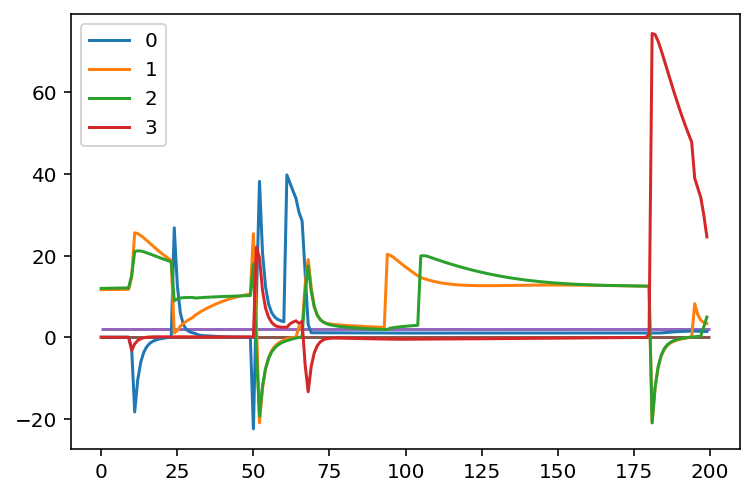

In [7]:
s = slice(0, 200)
plt.plot(grfs[s, :, 2])
plt.hlines(2, s.start, s.stop, color='C4')
plt.hlines(0, s.start, s.stop, color='C5')
plt.legend(range(4))

In [8]:
print(np.min(grfs[s, 3, 2]), np.max(grfs[np.argmin(grfs[0:100, 2, 2]):200, 2, 2]))

-13.338114115407437 19.970915673923397


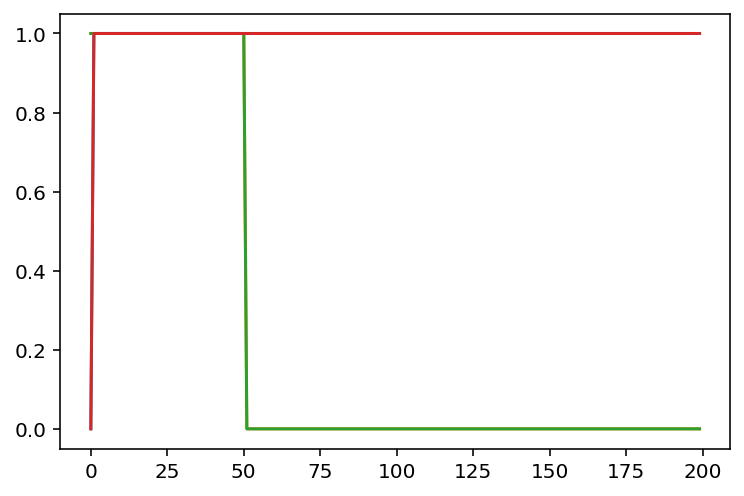

In [9]:
plt.plot(contact_hardcoded[s, :])

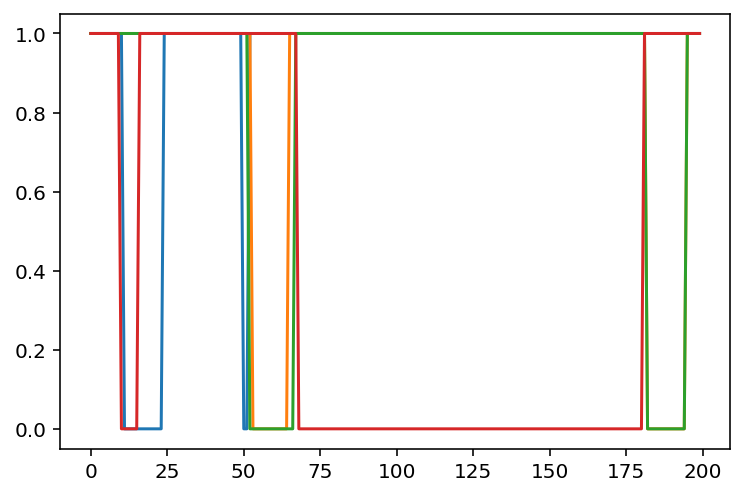

In [10]:
plt.plot(contact[s])

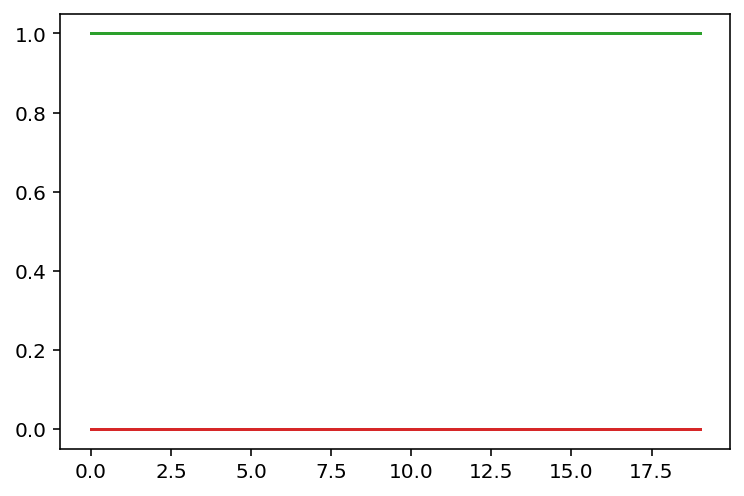

In [11]:
plt.plot(np.where(grfs[0:20, :, 2] > 1, 1., 0.))